In [34]:
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [35]:
def find_repo_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    cur = start.resolve()
    for p in [cur] + list(cur.parents):
        if (p / "pyproject.toml").exists() or (p / "data").exists():
            return p
    return cur

ROOT = find_repo_root()
DATA_DIR = ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RUNS_DIR = PROCESSED_DIR / "_runs"
CLEARED_DIR = PROCESSED_DIR / "data_cleared"

print("ROOT:", ROOT)
print("CLEARED_DIR:", CLEARED_DIR)
print("RUNS_DIR:", RUNS_DIR)


ROOT: /mnt/d/community-detection
CLEARED_DIR: /mnt/d/community-detection/data/processed/data_cleared
RUNS_DIR: /mnt/d/community-detection/data/processed/_runs


In [36]:
COMPARE_PAIR = ("brightkite", "lbsn2vec")

RUN_ID_BY_DATASET = {
    "brightkite": "20251214_192049",
    "lbsn2vec": "20251214_183903",
}

def dataset_paths(dataset: str) -> dict:
    dataset = dataset.lower()
    cleared = CLEARED_DIR / dataset
    run_id = RUN_ID_BY_DATASET.get(dataset)
    run_dir = (RUNS_DIR / run_id / dataset) if run_id else None
    run_cfg = (RUNS_DIR / run_id / "run_config.json") if run_id else None
    return {
        "dataset": dataset,
        "cleared_dir": cleared,
        "run_id": run_id,
        "run_dir": run_dir,
        "run_config": run_cfg,
    }

for ds in COMPARE_PAIR:
    print(dataset_paths(ds))


{'dataset': 'brightkite', 'cleared_dir': PosixPath('/mnt/d/community-detection/data/processed/data_cleared/brightkite'), 'run_id': '20251214_192049', 'run_dir': PosixPath('/mnt/d/community-detection/data/processed/_runs/20251214_192049/brightkite'), 'run_config': PosixPath('/mnt/d/community-detection/data/processed/_runs/20251214_192049/run_config.json')}
{'dataset': 'lbsn2vec', 'cleared_dir': PosixPath('/mnt/d/community-detection/data/processed/data_cleared/lbsn2vec'), 'run_id': '20251214_183903', 'run_dir': PosixPath('/mnt/d/community-detection/data/processed/_runs/20251214_183903/lbsn2vec'), 'run_config': PosixPath('/mnt/d/community-detection/data/processed/_runs/20251214_183903/run_config.json')}


In [37]:
def read_json_safe(p: Path) -> dict | None:
    try:
        with open(p, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] JSON read failed: {p} -> {type(e).__name__}: {e}")
        return None

def read_parquet_safe(p: Path, columns=None) -> pd.DataFrame | None:
    try:
        return pd.read_parquet(p, columns=columns)
    except Exception as e:
        print(f"[WARN] Parquet read failed: {p} -> {type(e).__name__}: {e}")
        return None


In [38]:
def normalize_user_id(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.str.replace(r"\.0$", "", regex=True)  # "123.0" -> "123"
    s = s.replace({"nan": np.nan, "None": np.nan})
    return s

def normalize_edges(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "u" not in df.columns or "v" not in df.columns:
        df = df.rename(columns={df.columns[0]: "u", df.columns[1]: "v"})
    df["u"] = normalize_user_id(df["u"])
    df["v"] = normalize_user_id(df["v"])
    df = df.dropna(subset=["u", "v"])
    return df

def normalize_users(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "user_id" not in df.columns:
        df = df.rename(columns={df.columns[0]: "user_id"})
    df["user_id"] = normalize_user_id(df["user_id"])
    df = df.dropna(subset=["user_id"])
    return df

def normalize_checkins(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["user_id"] = normalize_user_id(df["user_id"])
    df = df.dropna(subset=["user_id"])
    return df


In [39]:
def load_comm_df(run_dir: Path) -> pd.DataFrame:
    p_rep = run_dir / "comm_df.repaired.parquet"
    p_plain = run_dir / "comm_df.parquet"
    if p_rep.exists():
        df = pd.read_parquet(p_rep)
    elif p_plain.exists():
        df = pd.read_parquet(p_plain)
    else:
        raise FileNotFoundError(f"Missing comm_df(.repaired) in {run_dir}")

    if "user_id" not in df.columns:
        raise ValueError("comm_df missing user_id")

    if "community_id" not in df.columns:
        for alt in ["community", "comm_id", "cluster_id"]:
            if alt in df.columns:
                df = df.rename(columns={alt: "community_id"})
                break
    if "community_id" not in df.columns:
        raise ValueError("comm_df missing community_id (or alt)")

    df = df[["user_id", "community_id"]].copy()
    df["user_id"] = normalize_user_id(df["user_id"])
    df = df.dropna(subset=["user_id"])
    df["community_id"] = df["community_id"].astype(int)
    return df


In [40]:
REQUIRED_CLEARED = ["edges_final.parquet", "users_final.parquet", "checkins_final.parquet"]

def load_step8_bundle(ds: str) -> dict:
    info = dataset_paths(ds)
    if not info["cleared_dir"].exists():
        raise FileNotFoundError(info["cleared_dir"])
    if info["run_dir"] is None or not info["run_dir"].exists():
        raise FileNotFoundError(info["run_dir"])

    for fn in REQUIRED_CLEARED:
        p = info["cleared_dir"] / fn
        if not p.exists():
            raise FileNotFoundError(p)

    edges = read_parquet_safe(info["cleared_dir"] / "edges_final.parquet")
    users = read_parquet_safe(info["cleared_dir"] / "users_final.parquet")
    checkins = read_parquet_safe(info["cleared_dir"] / "checkins_final.parquet")
    if edges is None or users is None or checkins is None:
        raise RuntimeError("Failed to load cleared parquet(s)")

    edges = normalize_edges(edges)
    users = normalize_users(users)
    checkins = normalize_checkins(checkins)

    comm_df = load_comm_df(info["run_dir"])

    metrics_global = read_json_safe(info["run_dir"] / "metrics_global.json")
    run_config = read_json_safe(info["run_config"]) if info["run_config"] and info["run_config"].exists() else None

    return dict(
        dataset=ds,
        edges_final=edges,
        users_final=users,
        checkins_final=checkins,
        comm_df=comm_df,
        metrics_global_cache=metrics_global,
        run_config=run_config,
        paths=info,
    )

data_A = load_step8_bundle(COMPARE_PAIR[0])
data_B = load_step8_bundle(COMPARE_PAIR[1])

print("Loaded bundles:", data_A["dataset"], data_B["dataset"])
print("A:", data_A["users_final"].shape, data_A["edges_final"].shape, data_A["checkins_final"].shape, data_A["comm_df"].shape)
print("B:", data_B["users_final"].shape, data_B["edges_final"].shape, data_B["checkins_final"].shape, data_B["comm_df"].shape)


Loaded bundles: brightkite lbsn2vec
A: (15092, 1) (116506, 2) (3656191, 5) (8556, 2)
B: (47389, 1) (279816, 2) (10328914, 5) (11829, 2)


In [41]:
def make_labeled_views(bundle: dict) -> dict:
    users_all = set(bundle["users_final"]["user_id"].unique())

    comm_df = bundle["comm_df"].copy()
    comm_df = comm_df[comm_df["user_id"].isin(users_all)].copy()

    labeled_users = set(comm_df["user_id"].unique())

    edges = bundle["edges_final"].copy()
    edges_labeled = edges[edges["u"].isin(labeled_users) & edges["v"].isin(labeled_users)].copy()

    checkins = bundle["checkins_final"].copy()
    checkins_labeled = checkins[checkins["user_id"].isin(labeled_users)].copy()

    cov = {
        "users_total": int(len(users_all)),
        "users_labeled": int(len(labeled_users)),
        "label_coverage": float(len(labeled_users) / max(1, len(users_all))),
        "edges_total": int(len(edges)),
        "edges_labeled": int(len(edges_labeled)),
        "edge_labeled_ratio": float(len(edges_labeled) / max(1, len(edges))),
        "checkins_total": int(len(checkins)),
        "checkins_labeled": int(len(checkins_labeled)),
        "checkins_labeled_ratio": float(len(checkins_labeled) / max(1, len(checkins))),
    }

    out = bundle.copy()
    out["comm_df_labeled"] = comm_df
    out["edges_labeled"] = edges_labeled
    out["checkins_labeled"] = checkins_labeled
    out["coverage"] = cov
    return out

data_A = make_labeled_views(data_A)
data_B = make_labeled_views(data_B)

print("Coverage A:", data_A["coverage"])
print("Coverage B:", data_B["coverage"])


Coverage A: {'users_total': 15092, 'users_labeled': 5346, 'label_coverage': 0.35422740524781343, 'edges_total': 116506, 'edges_labeled': 49536, 'edge_labeled_ratio': 0.42517981906511254, 'checkins_total': 3656191, 'checkins_labeled': 2068469, 'checkins_labeled_ratio': 0.565744240385691}
Coverage B: {'users_total': 47389, 'users_labeled': 771, 'label_coverage': 0.016269598430015405, 'edges_total': 279816, 'edges_labeled': 1227, 'edge_labeled_ratio': 0.004385024444635046, 'checkins_total': 10328914, 'checkins_labeled': 160359, 'checkins_labeled_ratio': 0.015525252703236759}


In [42]:
def try_compute_modularity_igraph(edges_df: pd.DataFrame, comm_df: pd.DataFrame) -> float | None:
    try:
        import igraph as ig
    except Exception:
        return None

    nodes = pd.Index(pd.unique(pd.concat([edges_df["u"], edges_df["v"]], ignore_index=True)))
    node2idx = {u: i for i, u in enumerate(nodes.tolist())}
    edgelist = list(zip(edges_df["u"].map(node2idx), edges_df["v"].map(node2idx)))

    g = ig.Graph(n=len(nodes), edges=edgelist, directed=False)
    g.simplify(multiple=True, loops=True)

    comm_map = comm_df.set_index("user_id")["community_id"].to_dict()
    membership = [comm_map.get(u, -1) for u in nodes.tolist()]
    valid_idx = [i for i, m in enumerate(membership) if m != -1]

    if len(valid_idx) != len(membership):
        g = g.induced_subgraph(valid_idx)
        membership = [membership[i] for i in valid_idx]

    uniq = {c: i for i, c in enumerate(sorted(set(membership)))}
    membership = [uniq[c] for c in membership]
    return float(g.modularity(membership))

def compute_structural_comm_metrics(edges_df: pd.DataFrame, comm_df: pd.DataFrame) -> pd.DataFrame:
    u2c = comm_df.set_index("user_id")["community_id"]

    df = edges_df.copy()
    df["cu"] = df["u"].map(u2c)
    df["cv"] = df["v"].map(u2c)
    df = df.dropna(subset=["cu", "cv"])
    df["cu"] = df["cu"].astype(int)
    df["cv"] = df["cv"].astype(int)

    deg = pd.concat([edges_df["u"], edges_df["v"]], ignore_index=True).value_counts()
    deg = deg.rename_axis("user_id").reset_index(name="deg")
    deg["user_id"] = deg["user_id"].astype(str)
    deg = deg.merge(comm_df, on="user_id", how="inner")

    vol_by_comm = deg.groupby("community_id")["deg"].sum().rename("volume")
    total_vol = float(vol_by_comm.sum())

    internal = (
        df[df["cu"] == df["cv"]]
        .groupby("cu").size()
        .rename("internal_edges")
        .rename_axis("community_id")
    )

    cut_df = df[df["cu"] != df["cv"]][["cu", "cv"]]
    cut_counts = (
        pd.concat([cut_df["cu"].value_counts(), cut_df["cv"].value_counts()], axis=0)
        .groupby(level=0).sum()
        .rename("cut_edges")
        .rename_axis("community_id")
    )

    sizes = comm_df.groupby("community_id")["user_id"].nunique().rename("n_nodes").rename_axis("community_id")

    out = pd.concat([sizes, vol_by_comm, internal, cut_counts], axis=1).fillna(0)
    out.index.name = "community_id"
    out = out.reset_index()

    out["internal_edges"] = out["internal_edges"].astype(float)
    out["cut_edges"] = out["cut_edges"].astype(float)
    out["volume"] = out["volume"].astype(float)
    out["n_nodes"] = out["n_nodes"].astype(int)

    denom = np.minimum(out["volume"].values, total_vol - out["volume"].values)
    denom = np.where(denom <= 0, np.nan, denom)
    out["conductance"] = out["cut_edges"].values / denom

    n = out["n_nodes"].values.astype(float)
    denom_d = n * (n - 1.0) / 2.0
    denom_d = np.where(denom_d <= 0, np.nan, denom_d)
    out["density"] = out["internal_edges"].values / denom_d

    return out

def summarize_structural(comm_metrics: pd.DataFrame, modularity: float | None) -> dict:
    s = {"modularity": modularity}
    for col in ["conductance", "density"]:
        vals = comm_metrics[col].replace([np.inf, -np.inf], np.nan).dropna()
        s[f"{col}_median"] = float(vals.median()) if len(vals) else None
        s[f"{col}_iqr"] = float(vals.quantile(0.75) - vals.quantile(0.25)) if len(vals) else None
    return s


In [43]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c

def compute_user_centroids(checkins_df: pd.DataFrame) -> pd.DataFrame:
    return checkins_df.groupby("user_id", as_index=False)[["lat", "lon"]].mean()

def compute_spatial_comm_metrics(user_centroids: pd.DataFrame, comm_df: pd.DataFrame) -> pd.DataFrame:
    tmp = user_centroids.merge(comm_df, on="user_id", how="inner")
    sizes = tmp.groupby("community_id")["user_id"].nunique().rename("n_nodes")
    comm_cent = tmp.groupby("community_id")[["lat", "lon"]].mean().rename(columns={"lat": "comm_lat", "lon": "comm_lon"})
    tmp = tmp.merge(comm_cent, on="community_id", how="left")

    dist = haversine_km(tmp["lat"].values, tmp["lon"].values, tmp["comm_lat"].values, tmp["comm_lon"].values)
    tmp["dist_km"] = dist

    spatial = tmp.groupby("community_id")["dist_km"].median().rename("spatial_median_km")
    out = pd.concat([sizes, comm_cent, spatial], axis=1).reset_index()
    return out

def spatial_global_stat(comm_spatial: pd.DataFrame) -> float:
    vals = comm_spatial["spatial_median_km"].replace([np.inf, -np.inf], np.nan).dropna()
    return float(vals.median()) if len(vals) else float("nan")

def size_preserving_shuffle_labels(comm_ids: np.ndarray, sizes: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    labels = np.repeat(comm_ids, sizes)
    rng.shuffle(labels)
    return labels

def spatial_baseline_zscore_adaptive(user_centroids: pd.DataFrame,
                                    comm_df: pd.DataFrame,
                                    n_shuffles: int = 150,
                                    seed: int = 42,
                                    sample_users: int = 120000,
                                    min_comm_size: int = 20) -> dict:
    rng = np.random.default_rng(seed)
    tmp = user_centroids.merge(comm_df, on="user_id", how="inner")

    if len(tmp) == 0:
        return {
            "observed_global_spatial_median_km": float("nan"),
            "baseline_mean_km": float("nan"),
            "baseline_std_km": float("nan"),
            "spatial_z": float("nan"),
            "baseline_shuffles": int(n_shuffles),
            "baseline_sample_users": 0,
            "baseline_min_comm_size_used": None,
            "note": "No labeled users for spatial baseline.",
        }

    comm_sizes = tmp["community_id"].value_counts()

    thresholds = [min_comm_size, 10, 5, 2]
    chosen = None
    keep_comms = None
    for th in thresholds:
        kc = comm_sizes[comm_sizes >= th].index.values
        if len(kc) > 0:
            chosen = th
            keep_comms = kc
            break

    if chosen is None:
        return {
            "observed_global_spatial_median_km": float("nan"),
            "baseline_mean_km": float("nan"),
            "baseline_std_km": float("nan"),
            "spatial_z": float("nan"),
            "baseline_shuffles": int(n_shuffles),
            "baseline_sample_users": 0,
            "baseline_min_comm_size_used": None,
            "note": "No community passed any threshold (>=2).",
        }

    tmp = tmp[tmp["community_id"].isin(keep_comms)].copy()

    if len(tmp) > sample_users:
        tmp = tmp.sample(n=sample_users, random_state=seed)

    # observed
    observed_comm = compute_spatial_comm_metrics(tmp[["user_id", "lat", "lon"]], tmp[["user_id", "community_id"]])
    observed_global = spatial_global_stat(observed_comm)

    # shuffle setup
    comm_sizes2 = tmp["community_id"].value_counts().sort_index()
    comm_ids = comm_sizes2.index.values.astype(int)
    sizes = comm_sizes2.values.astype(int)

    user_lat = tmp["lat"].values
    user_lon = tmp["lon"].values

    baseline_vals = []
    for _ in range(n_shuffles):
        shuffled_labels = size_preserving_shuffle_labels(comm_ids, sizes, rng)

        tcoords = pd.DataFrame({"community_id": shuffled_labels, "lat": user_lat, "lon": user_lon})
        comm_cent = tcoords.groupby("community_id")[["lat", "lon"]].mean().rename(columns={"lat": "comm_lat", "lon": "comm_lon"})

        comm_lat = pd.Series(shuffled_labels).map(comm_cent["comm_lat"]).values
        comm_lon = pd.Series(shuffled_labels).map(comm_cent["comm_lon"]).values

        dist = haversine_km(user_lat, user_lon, comm_lat, comm_lon)
        tcoords["dist_km"] = dist
        comm_median = tcoords.groupby("community_id")["dist_km"].median()
        baseline_vals.append(float(comm_median.median()))

    baseline_vals = np.array(baseline_vals, dtype=float)
    mu = float(np.mean(baseline_vals))
    sd = float(np.std(baseline_vals) + 1e-12)
    z = (observed_global - mu) / sd

    return {
        "observed_global_spatial_median_km": float(observed_global),
        "baseline_mean_km": mu,
        "baseline_std_km": sd,
        "spatial_z": float(z),
        "baseline_shuffles": int(n_shuffles),
        "baseline_sample_users": int(len(tmp)),
        "baseline_min_comm_size_used": int(chosen),
        "note": None,
    }


In [44]:
def compute_dataset_metrics_coverage(bundle: dict,
                                    baseline_shuffles: int = 150,
                                    baseline_sample_users: int = 120000,
                                    baseline_min_comm_size: int = 20,
                                    seed: int = 42) -> dict:
    ds = bundle["dataset"]

    comm_df = bundle["comm_df_labeled"]
    edges_lab = bundle["edges_labeled"]
    chk_lab = bundle["checkins_labeled"]

    # structural on labeled subgraph
    modularity = try_compute_modularity_igraph(edges_lab, comm_df) if len(edges_lab) else None
    comm_struct = compute_structural_comm_metrics(edges_lab, comm_df) if len(edges_lab) else pd.DataFrame(columns=["community_id","n_nodes","volume","internal_edges","cut_edges","conductance","density"])
    structural_summary = summarize_structural(comm_struct, modularity)

    # spatial on labeled users checkins
    if len(chk_lab):
        user_cent = compute_user_centroids(chk_lab[["user_id","lat","lon"]])
        comm_spatial = compute_spatial_comm_metrics(user_cent, comm_df)
        baseline = spatial_baseline_zscore_adaptive(
            user_centroids=user_cent,
            comm_df=comm_df,
            n_shuffles=baseline_shuffles,
            seed=seed,
            sample_users=baseline_sample_users,
            min_comm_size=baseline_min_comm_size,
        )
    else:
        comm_spatial = pd.DataFrame(columns=["community_id","n_nodes","comm_lat","comm_lon","spatial_median_km"])
        baseline = {
            "observed_global_spatial_median_km": float("nan"),
            "baseline_mean_km": float("nan"),
            "baseline_std_km": float("nan"),
            "spatial_z": float("nan"),
            "baseline_shuffles": int(baseline_shuffles),
            "baseline_sample_users": 0,
            "baseline_min_comm_size_used": None,
            "note": "No labeled checkins.",
        }

    # community size stats from labels (not from intersection)
    comm_sizes = comm_df["community_id"].value_counts()
    out = {
        "dataset": ds,
        **bundle["coverage"],

        "communities_labeled": int(comm_df["community_id"].nunique()),
        "largest_comm": int(comm_sizes.max()) if len(comm_sizes) else 0,
        "median_comm": float(comm_sizes.median()) if len(comm_sizes) else float("nan"),

        **structural_summary,

        "spatial_median_km": baseline["observed_global_spatial_median_km"],
        "baseline_mean_km": baseline["baseline_mean_km"],
        "baseline_std_km": baseline["baseline_std_km"],
        "spatial_z": baseline["spatial_z"],
        "baseline_shuffles": baseline["baseline_shuffles"],
        "baseline_sample_users": baseline["baseline_sample_users"],
        "baseline_min_comm_size_used": baseline["baseline_min_comm_size_used"],
        "baseline_note": baseline["note"],

        "comm_struct": comm_struct,
        "comm_spatial": comm_spatial,
        "metrics_global_cache": bundle.get("metrics_global_cache"),
        "run_config": bundle.get("run_config"),
    }
    return out

metrics_A = compute_dataset_metrics_coverage(data_A)
metrics_B = compute_dataset_metrics_coverage(data_B)

print(metrics_A["dataset"], "users_total=", metrics_A["users_total"], "users_labeled=", metrics_A["users_labeled"], "edges_labeled=", metrics_A["edges_labeled"])
print(metrics_B["dataset"], "users_total=", metrics_B["users_total"], "users_labeled=", metrics_B["users_labeled"], "edges_labeled=", metrics_B["edges_labeled"])


brightkite users_total= 15092 users_labeled= 5346 edges_labeled= 49536
lbsn2vec users_total= 47389 users_labeled= 771 edges_labeled= 1227


In [45]:
def build_table1_row(m: dict) -> dict:
    return {
        "dataset": m["dataset"],

        # coverage
        "users_total": m["users_total"],
        "users_labeled": m["users_labeled"],
        "label_coverage": m["label_coverage"],

        "edges_total": m["edges_total"],
        "edges_labeled": m["edges_labeled"],
        "edge_labeled_ratio": m["edge_labeled_ratio"],

        "checkins_total": m["checkins_total"],
        "checkins_labeled": m["checkins_labeled"],
        "checkins_labeled_ratio": m["checkins_labeled_ratio"],

        # communities
        "communities_labeled": m["communities_labeled"],
        "largest_comm": m["largest_comm"],
        "median_comm": m["median_comm"],

        # structural
        "modularity": m["modularity"],
        "conductance_median": m["conductance_median"],
        "conductance_iqr": m["conductance_iqr"],
        "density_median": m["density_median"],
        "density_iqr": m["density_iqr"],

        # spatial
        "spatial_median_km": m["spatial_median_km"],
        "baseline_mean_km": m["baseline_mean_km"],
        "baseline_std_km": m["baseline_std_km"],
        "spatial_z": m["spatial_z"],
        "baseline_shuffles": m["baseline_shuffles"],
        "baseline_sample_users": m["baseline_sample_users"],
        "baseline_min_comm_size_used": m["baseline_min_comm_size_used"],
        "baseline_note": m["baseline_note"],
    }

table1 = pd.DataFrame([build_table1_row(metrics_A), build_table1_row(metrics_B)])
table1


,dataset,users_total,users_labeled,label_coverage,edges_total,edges_labeled,edge_labeled_ratio,checkins_total,checkins_labeled,checkins_labeled_ratio,communities_labeled,largest_comm,median_comm,modularity,conductance_median,conductance_iqr,density_median,density_iqr,spatial_median_km,baseline_mean_km,baseline_std_km,spatial_z,baseline_shuffles,baseline_sample_users,baseline_min_comm_size_used,baseline_note
0,brightkite,15092,5346,0.354227,116506,49536,0.425180,3656191,2068469,0.565744,5059,41,1.0,-0.000830,1.0,0.0,0.000751,0.00526,3379.503611,3608.769810,417.066037,-0.549712,150,215,20,None
1,lbsn2vec,47389,771,0.016270,279816,1227,0.004385,10328914,160359,0.015525,747,5,1.0,-0.003716,1.0,0.0,0.000000,0.00000,4882.574651,5383.825137,896.486997,-0.559127,150,20,5,None


In [50]:
def build_case_studies(m: dict) -> pd.DataFrame:
    comm_struct = m["comm_struct"].copy()
    comm_spatial = m["comm_spatial"].copy()

    if len(comm_struct) == 0:
        return pd.DataFrame(columns=[
            "dataset","community_id","n_nodes","density","conductance","spatial_median_km",
            "comm_lat","comm_lon","internal_edges","cut_edges","volume"
        ])

    # merge có suffix để tránh đè cột
    comm = comm_struct.merge(comm_spatial, on="community_id", how="left", suffixes=("_struct", "_spatial"))
    comm["dataset"] = m["dataset"]

    # ---- FIX CHÍNH: khôi phục n_nodes sau merge ----
    if "n_nodes" not in comm.columns:
        if "n_nodes_struct" in comm.columns:
            comm["n_nodes"] = comm["n_nodes_struct"]
        elif "n_nodes_spatial" in comm.columns:
            comm["n_nodes"] = comm["n_nodes_spatial"]

    # đảm bảo numeric
    comm["n_nodes"] = pd.to_numeric(comm["n_nodes"], errors="coerce")
    comm["spatial_median_km"] = pd.to_numeric(comm.get("spatial_median_km"), errors="coerce")

    # top 2 by size (ưu tiên cộng đồng có size lớn)
    top_size = comm.sort_values("n_nodes", ascending=False).head(2)

    # top 2 by spatial compactness
    # - lọc các community có spatial_median_km hợp lệ
    cand = comm[comm["spatial_median_km"].notna()].copy()
    if len(cand) == 0:
        # nếu không có spatial metrics thì chỉ trả top_size
        picked = top_size.drop_duplicates(subset=["community_id"]).reset_index(drop=True)
    else:
        # adaptive min size để tránh chọn cụm size=1 vô nghĩa
        min_size = max(5, int(np.nanmedian(comm["n_nodes"].values)) if len(comm) else 5)
        cand2 = cand[cand["n_nodes"] >= min_size].copy()
        if len(cand2) == 0:
            cand2 = cand

        top_spatial = cand2.sort_values("spatial_median_km", ascending=True).head(2)
        picked = pd.concat([top_size, top_spatial], ignore_index=True).drop_duplicates(subset=["community_id"]).reset_index(drop=True)

    cols = ["dataset","community_id","n_nodes","density","conductance","spatial_median_km",
            "comm_lat","comm_lon","internal_edges","cut_edges","volume"]
    cols = [c for c in cols if c in picked.columns]
    return picked[cols].reset_index(drop=True)

table2 = pd.concat([build_case_studies(metrics_A), build_case_studies(metrics_B)], ignore_index=True)
table2


,dataset,community_id,n_nodes,density,conductance,spatial_median_km,comm_lat,comm_lon,internal_edges,cut_edges,volume
0,brightkite,0,41,0.003659,0.992063,3379.503611,39.046652,-65.286946,3.0,750.0,756.0
1,brightkite,1,37,0.001502,0.995294,4533.481244,31.085748,-55.667667,1.0,423.0,425.0
2,brightkite,10,16,0.000000,1.000000,1894.045501,37.294255,-70.686324,0.0,164.0,164.0
3,brightkite,7,18,0.000000,1.000000,2286.417812,40.910990,-79.771888,0.0,149.0,149.0
4,lbsn2vec,1,5,0.000000,1.000000,4084.562581,36.925385,-36.352816,0.0,6.0,6.0
5,lbsn2vec,2,5,0.000000,1.000000,5680.586720,22.400500,-38.958954,0.0,25.0,25.0
6,lbsn2vec,3,5,0.000000,1.000000,2175.118187,32.958513,11.312373,0.0,15.0,15.0


In [48]:
def plot_compare_distributions(mA: dict, mB: dict, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)

    def _plot_hist(a, b, title, xlabel, fname, bins=60):
        a = a.replace([np.inf,-np.inf], np.nan).dropna()
        b = b.replace([np.inf,-np.inf], np.nan).dropna()
        plt.figure()
        plt.hist(a.values, bins=bins, alpha=0.6, label=mA["dataset"])
        plt.hist(b.values, bins=bins, alpha=0.6, label=mB["dataset"])
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("count")
        plt.legend()
        plt.tight_layout()
        plt.savefig(out_dir / fname, dpi=200)
        plt.show()

    if len(mA["comm_struct"]) and len(mB["comm_struct"]):
        _plot_hist(mA["comm_struct"]["conductance"], mB["comm_struct"]["conductance"],
                   "Conductance distribution (labeled communities)", "conductance", "conductance_hist.png", bins=50)

        _plot_hist(mA["comm_struct"]["density"], mB["comm_struct"]["density"],
                   "Density distribution (labeled communities)", "density", "density_hist.png", bins=50)

    if len(mA["comm_spatial"]) and len(mB["comm_spatial"]):
        _plot_hist(mA["comm_spatial"]["spatial_median_km"], mB["comm_spatial"]["spatial_median_km"],
                   "Spatial cohesion distribution (community median distance, km)", "spatial_median_km", "spatial_hist.png", bins=60)


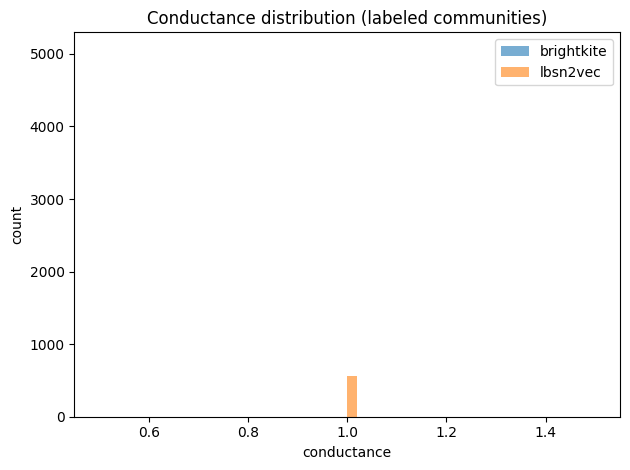

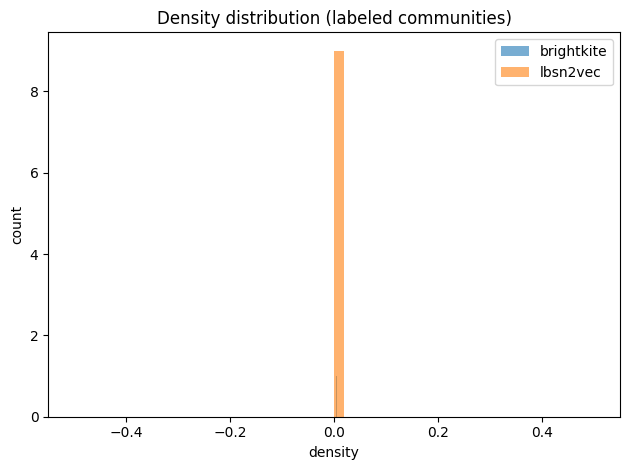

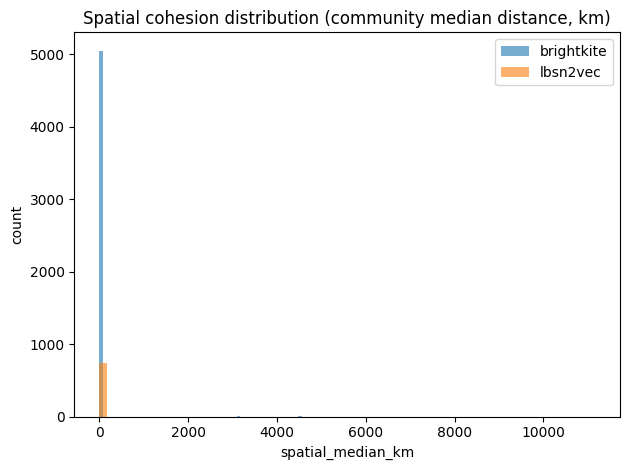

Saved Step 8 artifacts to: /mnt/d/community-detection/data/processed/_runs/20251217_205811/step8_compare
 - step8_global_summary.csv / .parquet
 - step8_case_studies.csv / .parquet
 - step8_notes.json
 - figures/*.png


In [49]:
STEP8_OUT = RUNS_DIR / f"{datetime.now():%Y%m%d_%H%M%S}" / "step8_compare"
FIG_DIR = STEP8_OUT / "figures"
STEP8_OUT.mkdir(parents=True, exist_ok=True)

table1.to_csv(STEP8_OUT / "step8_global_summary.csv", index=False)
table2.to_csv(STEP8_OUT / "step8_case_studies.csv", index=False)
table1.to_parquet(STEP8_OUT / "step8_global_summary.parquet", index=False)
table2.to_parquet(STEP8_OUT / "step8_case_studies.parquet", index=False)

notes = {
    "compare_pair": list(COMPARE_PAIR),
    "policy": {
        "ground_truth": "data_cleared",
        "community_labels": "_runs/comm_df.repaired",
        "comm_metrics": "ignored (corrupt)",
        "method": "coverage-aware labeled subgraph metrics; report coverage explicitly"
    },
    "coverage_A": metrics_A["users_total"], 
    "coverage_detail_A": {k: metrics_A[k] for k in [
        "users_total","users_labeled","label_coverage","edges_total","edges_labeled","edge_labeled_ratio",
        "checkins_total","checkins_labeled","checkins_labeled_ratio"
    ]},
    "coverage_detail_B": {k: metrics_B[k] for k in [
        "users_total","users_labeled","label_coverage","edges_total","edges_labeled","edge_labeled_ratio",
        "checkins_total","checkins_labeled","checkins_labeled_ratio"
    ]},
    "baseline": {
        "n_shuffles": int(metrics_A["baseline_shuffles"]),
        "adaptive_thresholds": [20,10,5,2],
        "definition": "size-preserving shuffle of labels; global stat = median of per-community median distances"
    },
    "run_config_A": metrics_A.get("run_config"),
    "run_config_B": metrics_B.get("run_config"),
    "metrics_global_cache_A": metrics_A.get("metrics_global_cache"),
    "metrics_global_cache_B": metrics_B.get("metrics_global_cache"),
}
with open(STEP8_OUT / "step8_notes.json", "w", encoding="utf-8") as f:
    json.dump(notes, f, ensure_ascii=False, indent=2)

plot_compare_distributions(metrics_A, metrics_B, FIG_DIR)

print("Saved Step 8 artifacts to:", STEP8_OUT)
print(" - step8_global_summary.csv / .parquet")
print(" - step8_case_studies.csv / .parquet")
print(" - step8_notes.json")
print(" - figures/*.png")
